<img width="10%" alt="Naas" src="https://landen.imgix.net/jtci2pxwjczr/assets/5ice39g4.png?w=160"/>

# GitHub - Send templates created on a notebooks to Slack channel
<a href="https://app.naas.ai/user-redirect/naas/downloader?url=https://raw.githubusercontent.com/jupyter-naas/awesome-notebooks/master/GitHub/GitHub_Reopen_issue.ipynb" target="_parent"><img src="https://naasai-public.s3.eu-west-3.amazonaws.com/Open_in_Naas_Lab.svg"/></a><br><br><a href="https://github.com/jupyter-naas/awesome-notebooks/issues/new?assignees=&labels=&template=template-request.md&title=Tool+-+Action+of+the+notebook+">Template request</a> | <a href="https://github.com/jupyter-naas/awesome-notebooks/issues/new?assignees=&labels=bug&template=bug_report.md&title=GitHub+-+Reopen+issue:+Error+short+description">Bug report</a> | <a href="https://app.naas.ai/user-redirect/naas/downloader?url=https://raw.githubusercontent.com/jupyter-naas/awesome-notebooks/master/Naas/Naas_Start_data_product.ipynb" target="_parent">Generate Data Product</a>

**Tags:** #github #templates #created #rest #api #snippet #operations #slack

**Author:** [Benjamin Filly](https://www.linkedin.com/in/benjamin-filly-05427727a/)

**Description:** This notebook explains how to reopened an issue on GitHub using the REST API.

**References:**
- [GitHub REST API Documentation](https://docs.github.com/en/rest/issues/issues?apiVersion=2022-11-28#update-an-issue)

## Input

### Import libraries

In [33]:
from github import Github
import naas
import pandas as pd
from naas_drivers import slack
import plotly.graph_objects as go
from PIL import Image
import io
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings("ignore")

### Setup Variables
- `github_token`: [GitHub token](https://help.github.com/en/github/authenticating-to-github/creating-a-personal-access-token-for-the-command-line)
- `repo_name`: name of the repository in two part: owner_name/repository_name
- `contributor_profile`: your GitHub username
- `cron`: cron params for naas scheduler
- `slack_bot_token`: [Slack Bot token](https://docs.celigo.com/hc/en-us/articles/7140655476507-How-to-create-an-app-and-retrieve-OAuth-token-in-Slack)
- `slack_channel`: The name of the channel you want to send the message

In [38]:
# Inputs
github_token = naas.secret.get("GITHUB_TOKEN") or "YOUR_GITHUB_TOKEN"
repo_name = "jupyter-naas/awesome-notebooks"
contributor_profile = "Benjifilly" #example: "FlorentLvr" 
cron = "30 9,12,17 * * 1-5"

# Outputs
slack_bot_token = naas.secret.get("SLACK_BOT_TOKEN") or "YOUR_SLACK_TOKEN"
slack_channel = "naas-templates-contributors" #example: "naas-templates-contributors"

## Model

### Connect to GitHub repo

In [3]:
# Connect to the GitHub API using pygithub library
g = Github(github_token)

# Get the repository
repo = g.get_repo(repo_name)

### Get PRs closed
So here we're filtering out all closed PRs on the `contributor_profile`, then we retrieve the files added by each PR and classify them by month and week.

In [4]:
# Get the closed PR
pull_requests = repo.get_pulls(state='closed', sort='updated', direction='desc')
print("✅ Pull Requests fetched:", pull_requests.totalCount)

# Iterate over the pull requests and filter by assignee
assigned_pull_requests = [pr for pr in pull_requests if pr.assignee and pr.assignee.login == contributor_profile]

# Print the closed PR count
print(f"📌Number of assigned closed PR: {len(assigned_pull_requests)}")

✅ Pull Requests fetched: 678
📌Number of assigned closed PR: 28


### Get templates added by PRs closed

In [5]:
# Create an empty list to store the files added in closed pull requests
files_added_month = []
files_added_week = []
files_added = []

# Get the current date
current_date = datetime.now()

# Iterate over the assigned closed pull requests
for pr in assigned_pull_requests:
    # Get files added
    files = pr.get_files()

    # Get the date the file was created
    file_created = pr.merged_at

    days_diff = None  # Initialize days_diff

    if file_created is not None:
        # Calculate the difference in days between the current date and file creation date
        days_diff = (current_date - file_created).days

        # Iterate over the files added in the pull request
        for file in files:
            if file.status == "added":
                file_path = file.filename
                file_url = file.raw_url

                # Prep data
                tmp = {
                    "file_path": file_path,
                    "file_url": file_url,
                    "file_created": pr.merged_at,
                    "pr_number": pr.number,
                    "pr_title": pr.title,
                    "pr_url": pr.url,
                }

                # Add the data to the respective lists based on the file creation date
                if days_diff is not None and days_diff <= 30:
                    files_added_month.append(tmp)
                if days_diff is not None and days_diff <= 7:
                    files_added_week.append(tmp)

                # Add the data to the files_added list
                files_added.append(tmp)

# Create a DataFrame from the files_added list
df_files_added = pd.DataFrame(files_added)

# Calculate the variation between the current month and the last month
current_month = current_date.month
last_month = current_month - 1 if current_month > 1 else 12
files_added_current_month = df_files_added[df_files_added['file_created'].dt.month == current_month]
files_added_last_month = df_files_added[df_files_added['file_created'].dt.month == last_month]
variation_month = len(files_added_current_month) - len(files_added_last_month)

# Calculate the variation between the current week and the last week
current_week = current_date.isocalendar()[1]
last_week = current_week - 1 if current_week > 1 else 52
files_added_current_week = df_files_added[df_files_added['file_created'].dt.isocalendar().week == current_week]
files_added_last_week = df_files_added[df_files_added['file_created'].dt.isocalendar().week == last_week]
variation_week = len(files_added_current_week) - len(files_added_last_week)

# Prepare the variation strings
variation_month_str = f"+{variation_month}" if variation_month > 0 else str(variation_month)
variation_week_str = f"+{variation_week}" if variation_week > 0 else str(variation_week)

# Print the number of files added and the variations
print(f"📈 Number of Files added: {len(df_files_added)}")
print(f"📁 Number of Files added this month: {len(files_added_current_month)} ({variation_month_str} vs last month)")
print(f"📂 Number of Files added this week: {len(files_added_current_week)} ({variation_week_str} vs last week)")

📈 Number of Files added: 33
📁 Number of Files added this month: 33 (+33 vs last month)
📂 Number of Files added this week: 11 (+6 vs last week)


### Create dataframe and make a graph
[Number of this week compared to last year.](https://www.calendrier-365.fr/numero-de-semaine.html)

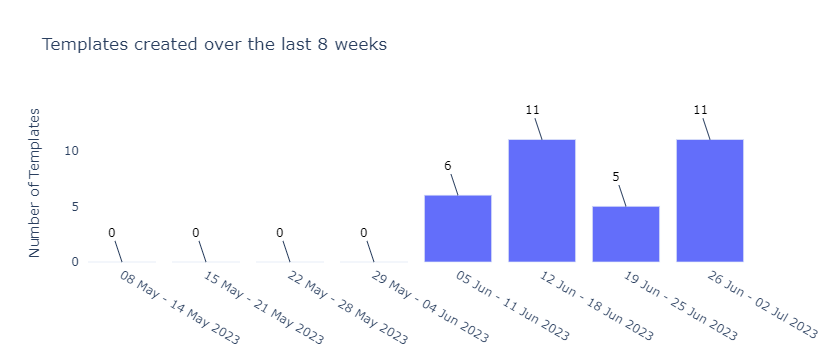

In [35]:
import plotly.graph_objects as go
from datetime import timedelta

# Prepare data for the bar chart
week_ranges = []  # List to store week ranges
files_added_by_week = []  # List to store the number of files added per week

# Get the current date
current_date = datetime.now().date()

# Get the start date of the current week (Monday)
current_start_date = current_date - timedelta(days=current_date.weekday())

# Iterate over the last 8 weeks
for i in range(8):
    start_date = current_start_date - timedelta(weeks=i)
    end_date = start_date + timedelta(days=6)
    week_range = f"{start_date.strftime('%d %b')} - {end_date.strftime('%d %b %Y')}"
    week_ranges.append(week_range)

    # Count the number of files added in the current week
    files_added_in_week = len([file for file in files_added if start_date <= file['file_created'].date() <= end_date])
    files_added_by_week.append(files_added_in_week)
    
# Create the bar chart
fig = go.Figure(data=go.Bar(x=week_ranges[::-1], y=files_added_by_week[::-1]))

# Add labels to each bar
for i, count in enumerate(files_added_by_week):
    fig.add_annotation(
        x=week_ranges[i],
        y=count,
        text=str(count),
        showarrow=True,
        font=dict(color="black", size=12),
        align="center",
        valign="bottom",
        textangle=0,  # Rotate the label horizontally
    )

# Update the layout of the chart
fig.update_layout(
    title="Templates created over the last 8 weeks",
    yaxis_title="Number of Templates",
    plot_bgcolor="white",
)

# Display the chart
fig.show()

# Convert the chart to a PNG image
image_bytes = fig.to_image(format="png")

# Create a PIL image from the image bytes
pil_image = Image.open(io.BytesIO(image_bytes))

### Creating the Slack message

In [36]:
blocks = [
    {
        "type": "header",
        "text": {
            "type": "plain_text",
            "text": f"{contributor_profile} - Activity update as of {current_date}",
            "emoji": True
        }
    },
    {
        "type": "divider"
    },
    {
        "type": "section",
        "text": {
            "type": "mrkdwn",
            "text": f"✅ *Templates created: {len(files_added)}*",
        }
    },
    {
        "type": "section",
        "text": {
            "type": "mrkdwn",
            "text": f"This month: {len(files_added_current_month)} ({variation_month_str} vs last month)\nThis week: {len(files_added_current_week)} ({variation_week_str} vs last week)"
        }
    },
    {
        "type": "section",
        "text": {
            "type": "mrkdwn",
            "text": "Here are the 5 latest files added this week:\n" + "\n".join([f"- <{file['file_url']}|{file['file_path']}>" for file in files_added_week[:5]])
        }
    },
    {
        "type": "divider"
    },
    {
        "type": "image",
        "title": {
            "type": "plain_text",
            "text": "Evolution by Week"
        },
        "image_url": f"{naas.assets.add(image_path)}",
        "alt_text": "Templates created over the last 8 weeks"
    }
]


👌 Well done! Your Assets has been sent to production.



<IPython.core.display.Javascript object>

Button(button_style='primary', description='Copy URL', style=ButtonStyle())

Output()

PS: to remove the "Assets" feature, just replace .add by .delete


## Output

### Send message on Slack

In [37]:
slack.connect(slack_bot_token).send(slack_channel, text=None, blocks=blocks)

✉️ Message sent


### Add scheduler

In [10]:
naas.scheduler.add(cron=cron)

👌 Well done! Your Notebook has been sent to production.

⏰ It will be scheduled "30 9,12,17 * * 1-5" (more on the syntax on https://crontab.guru/).

Ps: to remove the "Scheduler", just replace .add by .delete
